In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from data_cube import DataCube
from ssm import SSM
from similarity_network_fusion import SNF

In [2]:
from tslearn.metrics import dtw, dtw_path

In [3]:
dc = DataCube(
    subjects=["01"],
    gestures=["1", "2"],
    channels=["2", "4", "6", "8"],
    data_grp="parsed"
)
dc.load_data()
dc.rms_smooth(300, 20)
dc.normalize_modalities(smooth=True)

---

In [4]:
synrg_chan_dict = {"1":[0, 1, 4], "2":[0, 2, 3], "3":[0, 1, 2], "4":[0, 3, 4]}

In [5]:
def pass_synergist_channels(gnum, array):
    """
    pass synergist only channels for each gesture
    gnum - gesture number (i.e. 1, 2, 3, or 4)
    array - entire array of all channels and time index
    """
    synrgsts = {"1":[0, 1, 4], # channels 2 & 8; 0 is tidx
                "2":[0, 2, 3], # channels 4 & 6; 0 is tidx
                "3":[0, 1, 2], # channels 4 & 2; 0 is tidx
                "4":[0, 3, 4]} # channels 6 & 8; 0 is tidx
    synergist_array = np.c_[array[:, synrgsts[gnum][0]],
                            array[:, synrgsts[gnum][1]],
                            array[:, synrgsts[gnum][2]]]
    return synergist_array

---

subject 01; gesture 2_0_1


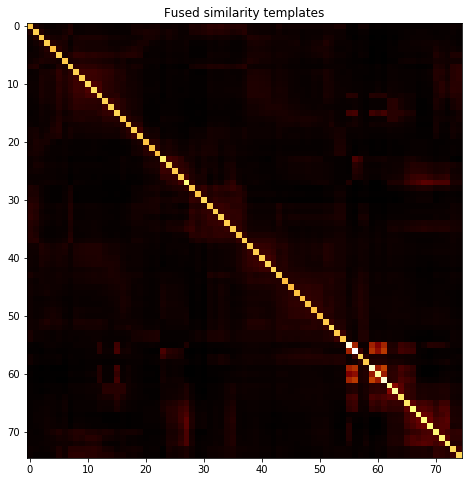

subject 01; gesture 2_0_2


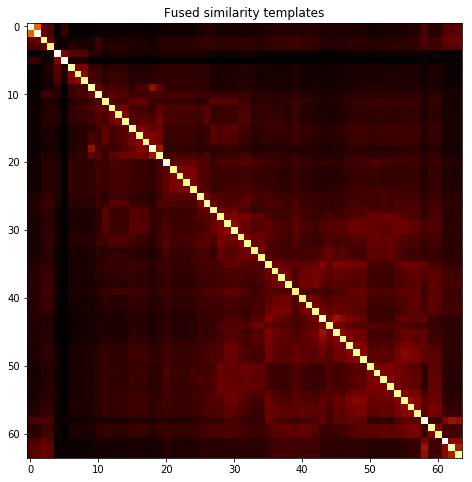

subject 01; gesture 1_1_2


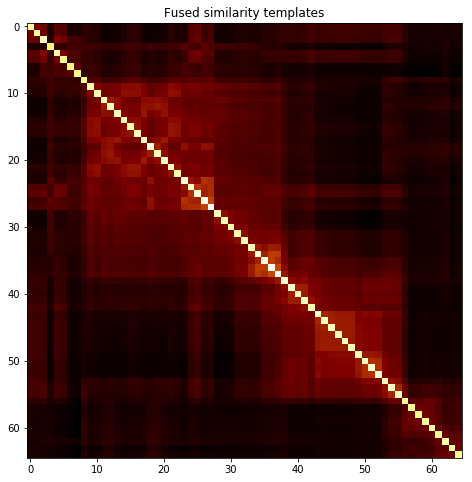

subject 01; gesture 2_1_2


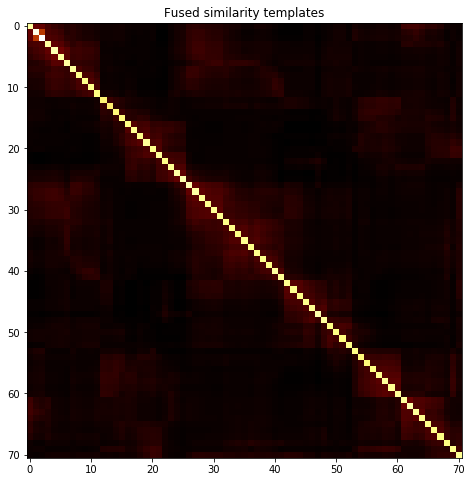

subject 01; gesture 1_1_1


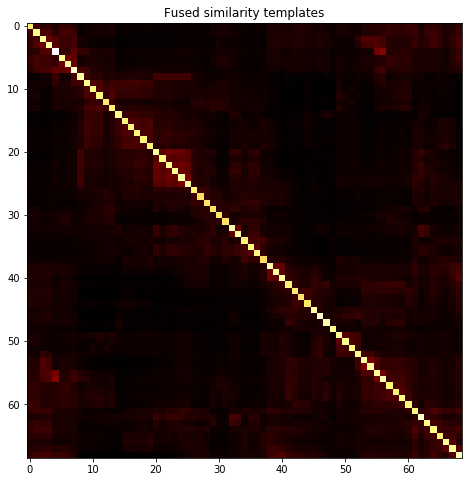

KeyboardInterrupt: 

In [6]:
dict_synerg = {}
for s, gdict in dc.data_set_smooth.items():
    dict_synerg[s] = {}
    for g, a in gdict.items():
        snf = SNF(pass_synergist_channels(g[0], a), k=0.2)
        # calculate graph weights to find knn
        snf.calc_weights()
        snf.normalize_weights()
        # generate and normalize knn graphs
        snf.calc_knn_weights()
        snf.normalize_knn_weights()
        # fuse graphs
        snf.network_fusion(iters=20)
        print(f"subject {s}; gesture {g}")
        snf.plot_template()
        # save template to dict
        dict_synerg[s][g] = snf.fused_similarity_template

In [12]:
a.shape

(72, 6)

In [9]:
from scipy.ndimage import gaussian_filter

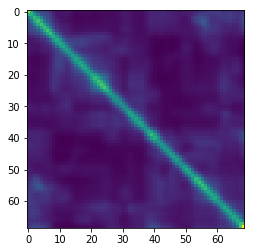

In [10]:
plt.imshow(gaussian_filter(dict_synerg["01"]["1_1_1"], 1))

---

subject 01; gesture 1_0_2; avg 0.4903501694850983; sd 0.021359223673025295
subject 01; gesture 1_0_2; PoV: 0.8710512892631019


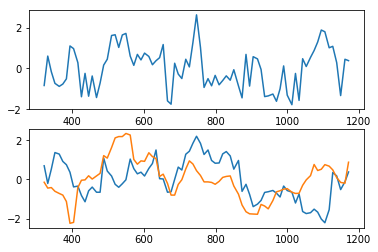

subject 01; gesture 2_1_2; avg 0.5777943681617786; sd 0.0314725866735608
subject 01; gesture 2_1_2; PoV: 0.8652245087661933


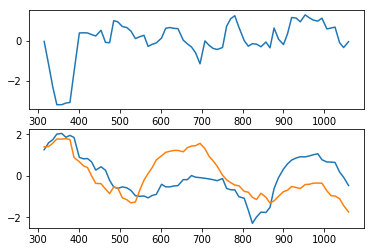

subject 01; gesture 1_0_1; avg 0.4389946346533654; sd 0.017874507023968554
subject 01; gesture 1_0_1; PoV: 0.8802766440384996


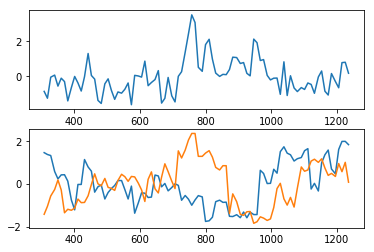

subject 01; gesture 2_1_1; avg 0.5723171633831107; sd 0.0563185413681927
subject 01; gesture 2_1_1; PoV: 0.8206368032120834


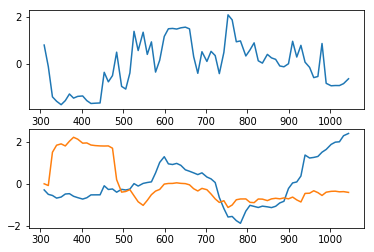

subject 01; gesture 1_1_1; avg 0.5871961282017524; sd 0.025625817318542684
subject 01; gesture 1_1_1; PoV: 0.8671189626969487


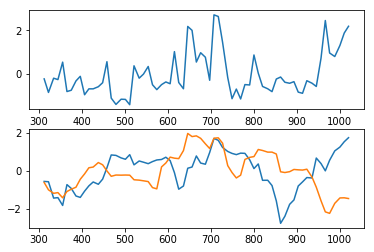

subject 01; gesture 2_0_1; avg 0.5703916045003716; sd 0.023277099502791294
subject 01; gesture 2_0_1; PoV: 0.887395665520586


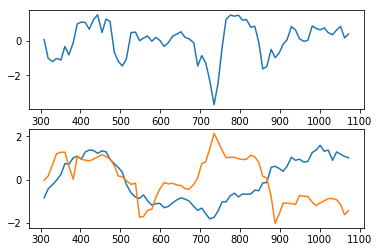

subject 01; gesture 1_1_2; avg 0.6208418621817821; sd 0.04051099206363616
subject 01; gesture 1_1_2; PoV: 0.8536862967911222


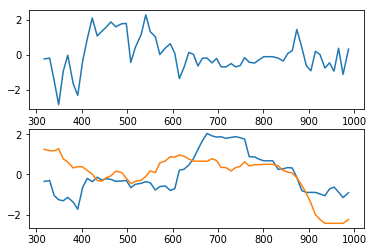

subject 01; gesture 2_0_2; avg 0.6400017276459058; sd 0.06156417674513235
subject 01; gesture 2_0_2; PoV: 0.8277238487961792


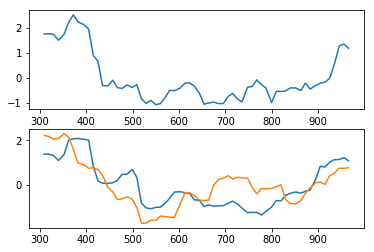

In [8]:
decomp_syn = {}

for s, gdict in dict_synerg.items():
    decomp_syn[s] = {}
    for g, a in gdict.items():
        print(f"subject {s}; gesture {g}; avg {a.mean()}; sd {a.std()}")
        evals, evecs = la.eig(a)
        evals = evals.real
        sort_idx = np.argsort(-evals)
        evals = evals[sort_idx]
        evecs = evecs[:, sort_idx]
        # calc percent of variance explained
        print(f"subject {s}; gesture {g}; PoV: {evals[0].real / evals.real.sum()}")
        # do PCA
        res = a @ evecs[:, 0]
        res = scale(res.real)
        decomp_syn[s][g] = res
        # plot results
        plt.subplot(211)
        plt.plot(dc.data_set_smooth[s][g][:,0], res)
        plt.subplot(212)
        plt.plot(dc.data_set_smooth[s][g][:,0],
                 dc.data_set_smooth[s][g][:,synrg_chan_dict[g[0]][1]])
        plt.plot(dc.data_set_smooth[s][g][:,0],
                 dc.data_set_smooth[s][g][:,synrg_chan_dict[g[0]][2]])
        plt.show()

---

In [9]:
# organize vectors by gesture
gest_dict = {"1":[], "2":[], "3":[], "4":[]}

for s, gdict in decomp_syn.items():
    for g, a in gdict.items():
        if g[0] not in ["1", "2", "3", "4"]: continue
        gest_dict[g[0]].append(a)

In [10]:
comp_dict = {"1":{"1":[], "2":[], "3":[], "4":[]},
             "2":{"1":[], "2":[], "3":[], "4":[]},
             "3":{"1":[], "2":[], "3":[], "4":[]},
             "4":{"1":[], "2":[], "3":[], "4":[]}}

for g1 in ["1", "2", "3", "4"]:
    for g2 in ["1", "2", "3", "4"]:
        for i in range(144):
            for j in range(144):
                if i == j and g1 == g2: continue
                comp_dict[g1][g2].append(dtw(gest_dict[g1][i], gest_dict[g2][j]))

IndexError: list index out of range

In [ ]:
for g1 in ["1", "2", "3", "4"]:
    print(f"gesture {g1} dtw similarities w/ other gestures:")
    for g2 in ["1", "2", "3", "4"]:
        print(f"avg similarity vs gesture {g2}: {np.mean(comp_dict[g1][g2])}")